In [1]:
import numpy as np
from Helpers.header import *

In [2]:
def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X

    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """
    # Math? See https://stackoverflow.com/questions/37009647
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D

In [3]:
def softmax(X, diag_zero=True):
    """Take softmax of each row of matrix X."""

    # Subtract max for numerical stability
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    # We usually want diagonal probailities to be 0.
    if diag_zero:
        np.fill_diagonal(e_x, 0.)

    # Add a tiny constant for stability of log we take later
    e_x = e_x + 1e-8  # numerical stability

    return e_x / e_x.sum(axis=1).reshape([-1, 1])

In [4]:
def calc_prob_matrix(distances, sigmas=None):
    """Convert a distances matrix to a matrix of probabilities."""
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)

In [5]:
def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, 
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess

In [6]:
def calc_perplexity(prob_matrix):
    """Calculate the perplexity of each row 
    of a matrix of probabilities."""
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity

In [7]:
def perplexity(distances, sigmas):
    """Wrapper function for quick calculation of 
    perplexity over a distance matrix."""
    return calc_perplexity(calc_prob_matrix(distances, sigmas))

In [8]:
def find_optimal_sigmas(distances, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

In [9]:
def q_joint(Y):
    """Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    # Get the distances from every point to every other
    distances = neg_squared_euc_dists(Y)
    # Take the elementwise exponent
    exp_distances = np.exp(distances)
    # Fill diagonal with zeroes so q_ii = 0
    np.fill_diagonal(exp_distances, 0.)
    # Divide by the sum of the entire exponentiated matrix
    return exp_distances / np.sum(exp_distances), None

In [10]:
def p_conditional_to_joint(P):
    """Given conditional probabilities matrix P, return
    approximation of joint distribution probabilities."""
    return (P + P.T) / (2. * P.shape[0])

In [11]:
def p_joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    P = p_conditional_to_joint(p_conditional)
    return P

In [12]:
def symmetric_sne_grad(P, Q, Y, _):
    """Estimate the gradient of the cost with respect to Y"""
    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)  #NxNx1
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  #NxNx2
    grad = 4. * (pq_expanded * y_diffs).sum(1)  #Nx2
    return grad

In [13]:
def estimate_sne(X, y, P, rng, num_iters, q_fn, grad_fn, learning_rate,
                 momentum, plot):
    """Estimates a SNE model.

    # Arguments
        X: Input data matrix.
        y: Class labels for that matrix.
        P: Matrix of joint probabilities.
        rng: np.random.RandomState().
        num_iters: Iterations to train for.
        q_fn: Function that takes Y and gives Q prob matrix.
        plot: How many times to plot during training.
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """

    # Initialise our 2D representation
    Y = rng.normal(0., 0.0001, [X.shape[0], 2])

    # Initialise past values (used for momentum)
    if momentum:
        Y_m2 = Y.copy()
        Y_m1 = Y.copy()

    # Start gradient descent loop
    for i in range(num_iters):

        # Get Q and distances (distances only used for t-SNE)
        Q, distances = q_fn(Y)
        # Estimate gradients with respect to Y
        grads = grad_fn(P, Q, Y, distances)

        # Update Y
        Y = Y - learning_rate * grads
        if momentum:  # Add momentum
            Y += momentum * (Y_m1 - Y_m2)
            # Update previous Y's for momentum
            Y_m2 = Y_m1.copy()
            Y_m1 = Y.copy()

        # Plot sometimes
        if plot and i % (num_iters / plot) == 0:
            categorical_scatter_2d(Y, y, alpha=1.0, ms=6,
                                   show=True, figsize=(9, 6))

    return Y

In [14]:
from Helpers.categorical_scatter_2d import *

In [15]:
from sklearn.datasets import load_digits
mnist = load_digits()

X = pd.DataFrame(mnist.data).head()
X

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [16]:
def q_tsne(Y):
    """t-SNE: Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances), inv_distances

In [17]:
def tsne_grad(P, Q, Y, inv_distances):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad

In [18]:
# Set global parameters
NUM_POINTS = 200            # Number of samples from MNIST
CLASSES_TO_USE = [0, 1, 8]  # MNIST classes to use
PERPLEXITY = 20
SEED = 1                    # Random seed
MOMENTUM = 0.9
LEARNING_RATE = 10.
NUM_ITERS = 500             # Num iterations to train for
TSNE = True                # If False, Symmetric SNE
NUM_PLOTS = 5               # Num. times to plot in training


def main():
    # numpy RandomState for reproducibility
    rng = np.random.RandomState(SEED)

    # Load the first NUM_POINTS 0's, 1's and 8's from MNIST
    # X = load_from_csv('Datasets/mnist_test.csv')
    # X = pd.DataFrame(X).to_numpy()
    # X = X[:, 1:]
    # print(X.shape)
    # print(X)
    # print("alskdjasl;kdj")
    # X = X[:NUM_POINTS]
    # print(X.shape)
    # print(X)
    # y = X[:, [0]]
    # y = y[:NUM_POINTS]
    # print(y)
    # print(y.shape)
    dataset = load_from_csv('Datasets/mnist_test.csv')
    train_data = dataset.sample(n=500, random_state=42)

    y = train_data['label']

    X = train_data.drop(columns=['label'])
    X = run_PCA(train_data, y, 2)
    X = X.drop(columns=['label'])
    X = pd.DataFrame(X).to_numpy()

    # Obtain matrix of joint probabilities p_ij
    P = p_joint(X, PERPLEXITY)

    # Fit SNE or t-SNE
    Y = estimate_sne(X, y, P, rng,
             num_iters=NUM_ITERS,
             q_fn=q_tsne if TSNE else q_joint,
             grad_fn=tsne_grad if TSNE else symmetric_sne_grad,
             learning_rate=LEARNING_RATE,
             momentum=MOMENTUM,
             plot=NUM_PLOTS)

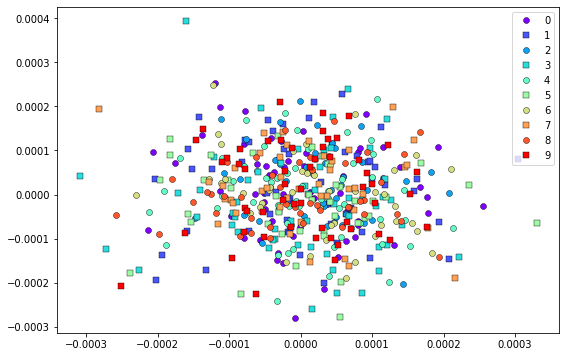

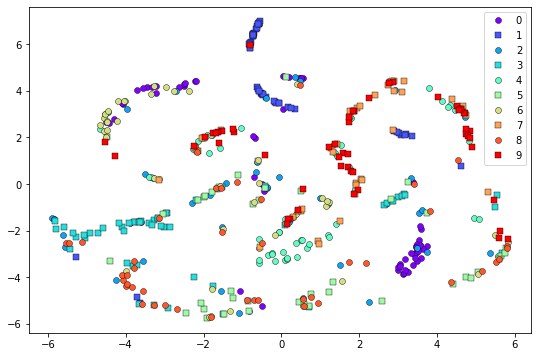

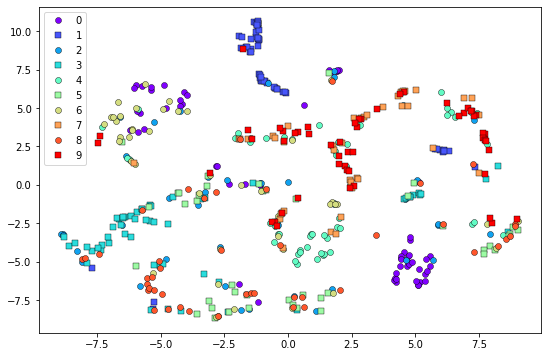

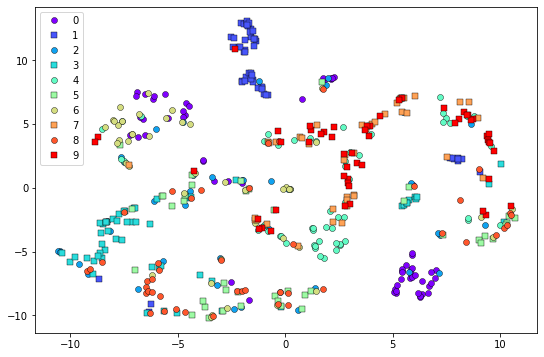

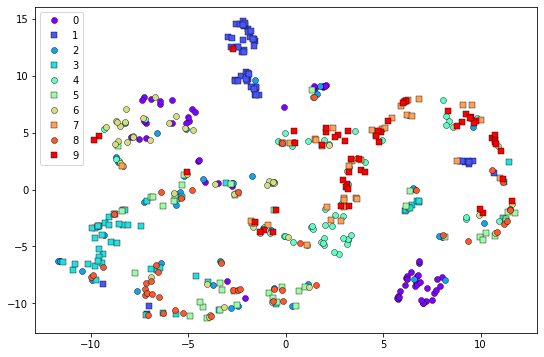

In [19]:
main()